<a href="https://colab.research.google.com/github/EliasEconomou/DataMining1-Sentiment-Analysis/blob/main/DataMining1_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Libraries and Reading Datafile**

In [104]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import re
import sys
import os.path
#!pip install --user -U nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from wordcloud import WordCloud

from itertools import chain
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [105]:
# Options
pd.options.mode.chained_assignment = None

In [106]:
# Reading data file
fileExists = os.path.exists("./drive/MyDrive/ColabNotebooks/eclass_all_with_sentiment_v2.pkl")
if fileExists:
  DF = pd.read_pickle("./drive/MyDrive/ColabNotebooks/eclass_all_with_sentiment_v2.pkl")
else:
  print('Enter data file path:')
  filePath = input()
  DF = pd.read_pickle(filePath)


# **Preprocessing and Cleaning Data**

In [107]:
# Choose a subset of the dataset's tweets
numOfRows = DF.shape[0]
percentage = 4
df = DF.iloc[:int(percentage*0.01*numOfRows)]
print("Chosen number of tweets is {}.".format(df.shape[0]))

Chosen number of tweets is 9128.


In [108]:
# Remove punctuation, links, hashtags, new lines etc, using regular expressions
df["text"] = df["text"].replace('\.|,|\?|!|:|\(|\)|%|\$','', regex=True)
df["text"] = df["text"].replace('\n|\t','', regex=True)
df["text"] = df["text"].replace(r'(http\S+)|(www\S+)|(#\S+)|(&\S+)|(@\S+)','', regex=True)
df["text"] = df["text"].replace('(\s-\s)','', regex=True)

# Remove emojis by encoding - decoding into ascii, resulting in ignoring emojis
df["text"] = df["text"].apply(lambda x: x.encode('ascii', 'ignore').decode('ascii'))

# Convert text to lowercase
df["text"] = df["text"].str.lower()

# Remove stopwords like 'i','is','you', etc
stopWords = list(stopwords.words('english'))
stopWords.remove("why")
stopWords.remove("how")
stopWords.remove("against")
stopWords.remove("again")
stopWords.remove("not")
stopWords.append("'ve")
stopWords.append("'re")
stopWords.append("'s")
stopWords.append("``")
stopWords.append("''")

# if "'d" in stopWords:
#   print(True)
# else:
#   print(False)
df["text"] = df["text"].apply(word_tokenize)
df["text"] = df["text"].apply(lambda words: [word for word in words if word not in stopWords])

# Remove any unnecessary spaces
df["text"] = df["text"].replace(' +', ' ', regex=True)

# Remove rows with empty data
df.text.dropna()


0       [folks, said, daikon, paste, could, treat, cyt...
1       [world, wrong, side, history, year, hopefully,...
2           [russian, vaccine, created, last, 2-4, years]
3       [facts, immutable, senator, even, not, ethical...
4                    [explain, again, why, need, vaccine]
                              ...                        
9123    [given, half, dose, vaccine, offers, similar, ...
9124    [heard, mrna, vaccines, know, how, work, covid...
9125    [highlight, weekend, volunteering, vaccinate, ...
9126    [152, days, post, 1pm, 2/132nd, covid, shot043...
9127              [us, secures, 200, million, doses, via]
Name: text, Length: 9128, dtype: object

In [109]:
df["sentiment"]

0       NEU
1       NEG
2       NEU
3       NEU
4       NEG
       ... 
9123    NEU
9124    NEU
9125    POS
9126    NEG
9127    NEU
Name: sentiment, Length: 9128, dtype: object

# **Analyzing Data**

**1.   Distribution of sentiments**

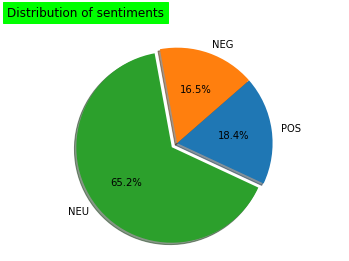

In [110]:
sentimentDict = {'POS' : 0, 'NEG' : 0, 'NEU' : 0}
for sentiment in df["sentiment"]:
  sentimentDict[sentiment] += 1

labels = sentimentDict.keys()
sizes = sentimentDict.values()
explode = [0, 0, 0.07]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=-25)
ax1.axis('equal')
plt.title(label="Distribution of sentiments",
          loc="left",
          pad='20.0',
          backgroundcolor='lime')
plt.show()



**2.   Most used words**

[('vaccine', 2762), ('dose', 946), ('first', 883), ('covid-19', 615), ('not', 537), ('vaccines', 529), ('today', 524), ('got', 521), ('covid', 441), ('second', 440), ('doses', 424), ('get', 420), ('people', 395), ('received', 332), ('pfizer', 329), ('vaccination', 318), ('new', 283), ('vaccinated', 282), ('2nd', 278), ('against', 267), ('how', 265), ('shot', 264), ('one', 263), ('use', 257), ('us', 247), ('health', 246), ('2', 237), ('day', 228), ('thank', 215), ('getting', 201), ('coronavirus', 190), ("n't", 185), ('side', 183), ('1st', 182), ('receive', 178), ('good', 178), ('effective', 176), ('done', 171), ('effects', 165), ('like', 164), ('million', 162), ('jab', 161), ('why', 160), ('week', 159), ('know', 159), ('approved', 153), ('arm', 150), ('days', 149), ('says', 149), ('said', 148)]


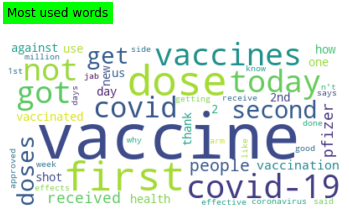

In [111]:
wordList = list(chain.from_iterable(list(df["text"])))
fdist = FreqDist(wordList)
#print(fdist.most_common(50))

wordcloud = WordCloud(max_words=50,
                      background_color='white',
                      contour_color='black',
                      contour_width=4).generate_from_frequencies(fdist)


plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(label='Most used words',
          loc="left",
          pad='25.0',
          backgroundcolor='lime')
plt.grid()
plt.show()

**3.   Most used words by tweet sentiment**

In [112]:
groupBySent = df.groupby('sentiment')


In [114]:
POSgroup = groupBySent.get_group('POS')
NEGgroup = groupBySent.get_group('NEG')
NEUgroup = groupBySent.get_group('NEU')